# Dense Neural Network for Text Classification

## Preliminaries

### Imports

In [1]:
import os
import pickle 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf4
import tensorflow.keras as keras

%matplotlib inline

import sys
sys.path.append("../..")
from E4525_ML.multiclass_logistic import LogisticGDClassifier

from E4525_ML import plots

/home/manel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
seed=456
np.random.seed(seed)

### Data

In [3]:
raw_data_dir="../..raw/speech_commands"

In [4]:
data_dir=r"../../data/speech_commands"
model_dir=r"../../data/models/tf/Speech_Commands_Pooling"

In [5]:
file=open(data_dir+"/mfcc.p","rb")
features_all,labels_all=pickle.load(file)

In [6]:
features,features_test,labels,labels_test=train_test_split(features_all,labels_all,test_size=0.1)
print(features.shape,len(features_test))

(58248, 20, 44) 6473


In [7]:
features_train,features_val,labels_train,labels_val=train_test_split(features,labels,test_size=0.1)
print(features_train.shape,len(features_val))

(52423, 20, 44) 5825


In [8]:
classes=np.unique(labels_train)
K=len(classes)
print(classes)
print(K)

['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes' 'zero']
30


In [9]:
N=features_train.shape[0]
D=features_train.shape[1]*features_train.shape[2]
print(N,D,K)

52423 880 30


## Logistic Classifier

In [10]:
log_model=LogisticGDClassifier(max_iter=300,tol=1e-8)#LogisticRegression(C=1e30,solver="newton-cg",multi_class="multinomial")
log_model.fit(features_train.reshape(len(features_train),-1),labels_train,features_val.reshape(len(features_val),-1),labels_val)

	 0 Loss = 22168.21468627461 Train_Accuracy 0.024 Evaluation Loss = 22075.970253217318 Accuracy = 0.03
	 30 Loss = 14966.803104461294 Train_Accuracy 0.35 Evaluation Loss = 15818.759588869092 Accuracy = 0.313
	 60 Loss = 15542.449377709805 Train_Accuracy 0.325 Evaluation Loss = 15910.862992588853 Accuracy = 0.309
	 90 Loss = 14943.777253531352 Train_Accuracy 0.351 Evaluation Loss = 15358.242570270282 Accuracy = 0.333
	 120 Loss = 14828.647998881652 Train_Accuracy 0.356 Evaluation Loss = 15680.604483289448 Accuracy = 0.319
	 150 Loss = 15081.932359110997 Train_Accuracy 0.345 Evaluation Loss = 16025.992247238555 Accuracy = 0.304
	 180 Loss = 15151.00991190082 Train_Accuracy 0.342 Evaluation Loss = 15841.78543979903 Accuracy = 0.312
	 210 Loss = 13953.665663543914 Train_Accuracy 0.394 Evaluation Loss = 14621.415340512187 Accuracy = 0.365
	 240 Loss = 14874.699700741532 Train_Accuracy 0.354 Evaluation Loss = 15611.526930499625 Accuracy = 0.322
	 270 Loss = 14598.389489582247 Train_Accuracy 

In [11]:
Y_pred=log_model.predict(features_train.reshape(len(features_train),-1))
np.mean(Y_pred==labels_train)

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.3977261888865574

In [12]:
Y_pred=log_model.predict(features_val.reshape(len(features_val),-1))
np.mean(Y_pred==labels_val)

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.3484978540772532

## Training Dense Neural Network on Speech Sound Features Data Set

In [13]:
num_classes=K
num_classes

30

In [14]:
encoder=LabelEncoder()
Y_train=encoder.fit_transform(labels_train)
Y_val=encoder.transform(labels_val)
Y_test=encoder.transform(labels_test)
Y=encoder.transform(labels)

In [15]:
class ReportCallback(keras.callbacks.Callback):
    def __init__(self,frequency,log_file,use_val=True):
        self.file=log_file
        self.freq=frequency
        self.use_val=use_val
        self.separator=" || "
        if not(self.use_val):
            self.separator="\n"
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % self.freq ==0):
            train_loss=logs["loss"]
            train_acc=logs["acc"]
            print(f"\t{epoch}: TRAIN loss {train_loss:.4f},  acc {train_acc:.4f}",end=self.separator)
            print(f"\t{epoch}: TRAIN loss {train_loss:.4f},  acc {train_acc:.4f}",end=self.separator,file=self.file)
            if self.use_val:
                val_loss=logs["val_loss"]
                val_acc=logs["val_acc"]
                print(f"VAL loss {val_loss:.4f}, acc {val_acc:.4f}")
                print(f"VAL loss {val_loss:.4f}, acc {val_acc:.4f}",file=self.file)
            self.file.flush()

In [16]:
def build_model(hidden1,hidden2):
    model=keras.Sequential([
        keras.layers.Flatten(input_shape=(20,44)),
        keras.layers.Dense(hidden1,activation="relu"),
        keras.layers.Dense(hidden2,activation="relu"),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(num_classes,activation="softmax")
    ])
    optimizer=keras.optimizers.Adam(lr=0.00005)
    #optimizer=keras.optimizers.SGD(lr=0.001) # for some reason Adam's does not converge for this dataset, but plain SGD does
    model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
    return model

In [17]:
log_file=open("progress.log","wt")

In [18]:
model0=build_model(512,512)
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 880)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               451072    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                15390     
Total params: 729,118
Trainable params: 729,118
Non-trainable params: 0
_________________________________________________________________


In [19]:
nepochs=200

In [20]:
result=model0.fit(features_train,Y_train,validation_data=(features_val,Y_val),
                  epochs=nepochs,batch_size=100,
                  verbose=0,callbacks=[ReportCallback(10,log_file)])

	0: TRAIN loss 15.3093,  acc 0.0475 || VAL loss 15.0726, acc 0.0625
	10: TRAIN loss 2.8110,  acc 0.2155 || VAL loss 2.4967, acc 0.2968
	20: TRAIN loss 1.5720,  acc 0.5190 || VAL loss 1.2792, acc 0.6324
	30: TRAIN loss 1.1118,  acc 0.6527 || VAL loss 0.9535, acc 0.7248
	40: TRAIN loss 0.8332,  acc 0.7335 || VAL loss 0.8019, acc 0.7701
	50: TRAIN loss 0.6577,  acc 0.7882 || VAL loss 0.7335, acc 0.7991
	60: TRAIN loss 0.5286,  acc 0.8248 || VAL loss 0.7068, acc 0.8065
	70: TRAIN loss 0.4325,  acc 0.8570 || VAL loss 0.6739, acc 0.8218
	80: TRAIN loss 0.3664,  acc 0.8770 || VAL loss 0.6572, acc 0.8266
	90: TRAIN loss 0.3059,  acc 0.8976 || VAL loss 0.6625, acc 0.8326
	100: TRAIN loss 0.2642,  acc 0.9108 || VAL loss 0.6755, acc 0.8361
	110: TRAIN loss 0.2281,  acc 0.9234 || VAL loss 0.7039, acc 0.8378
	120: TRAIN loss 0.2032,  acc 0.9313 || VAL loss 0.6950, acc 0.8462
	130: TRAIN loss 0.1789,  acc 0.9399 || VAL loss 0.7339, acc 0.8443
	140: TRAIN loss 0.1599,  acc 0.9466 || VAL loss 0.7316, 

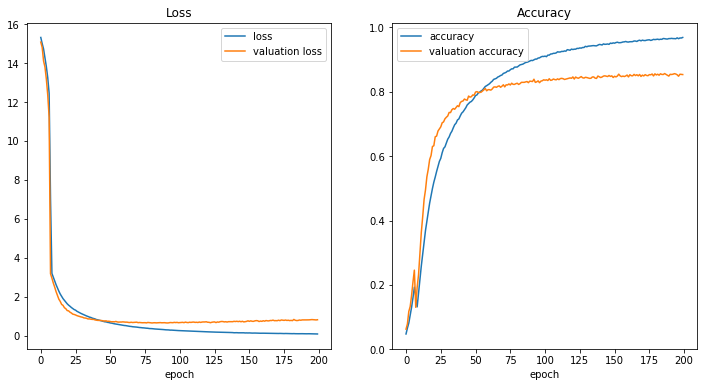

In [21]:
history=result.history
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history["loss"],label="loss")
plt.plot(history["val_loss"],label="valuation loss")
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["acc"],label="accuracy")
plt.plot(history["val_acc"],label="valuation accuracy")
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()

In [22]:
Y_pred=np.argmax(model0.predict(features_val),axis=1)
np.mean(Y_pred==Y_val)

0.8535622317596566

##  Neural Network Model

In [24]:
results=[]
for n_layer1 in [128,256,2*256,4*256,8*256]:
    for n_layer2 in [128,256,2*256,4*256,8*256]:
        # Build the Estimator
        model=build_model(n_layer1,n_layer2)
        model.fit(features_train,Y_train,validation_data=(features_val,Y_val),
                  epochs=nepochs,batch_size=100,
                  verbose=0,callbacks=[ReportCallback(10,log_file)])
        Y_pred=np.argmax(model.predict(features_train),axis=1)
        acc_train=np.mean(Y_pred==Y_train)
        Y_pred=np.argmax(model.predict(features_val),axis=1)
        acc_val=np.mean(Y_pred==Y_val)
        print(n_layer1,n_layer2,acc_train,acc_val)
        print(n_layer1,n_layer2,acc_train,acc_val,file=log_file)
        log_file.flush()
        results.append((n_layer1,n_layer2,acc_train,acc_val))

	0: TRAIN loss 15.3738,  acc 0.0386 || VAL loss 15.0007, acc 0.0597
	10: TRAIN loss 3.3565,  acc 0.0590 || VAL loss 3.3428, acc 0.0736
	20: TRAIN loss 3.0250,  acc 0.1531 || VAL loss 2.8553, acc 0.2177
	30: TRAIN loss 2.5293,  acc 0.2515 || VAL loss 2.2121, acc 0.3478
	40: TRAIN loss 2.2050,  acc 0.3229 || VAL loss 1.8558, acc 0.4630
	50: TRAIN loss 1.9707,  acc 0.3813 || VAL loss 1.6136, acc 0.5288
	60: TRAIN loss 1.7750,  acc 0.4370 || VAL loss 1.4384, acc 0.5825
	70: TRAIN loss 1.6170,  acc 0.4810 || VAL loss 1.2779, acc 0.6225
	80: TRAIN loss 1.4845,  acc 0.5250 || VAL loss 1.1862, acc 0.6558
	90: TRAIN loss 1.3674,  acc 0.5567 || VAL loss 1.1403, acc 0.6678
	100: TRAIN loss 1.2833,  acc 0.5822 || VAL loss 1.0914, acc 0.6826
	110: TRAIN loss 1.1984,  acc 0.6093 || VAL loss 1.0332, acc 0.6948
	120: TRAIN loss 1.1358,  acc 0.6300 || VAL loss 1.0028, acc 0.7088
	130: TRAIN loss 1.0766,  acc 0.6476 || VAL loss 0.9783, acc 0.7161
	140: TRAIN loss 1.0327,  acc 0.6586 || VAL loss 0.9715, 

	180: TRAIN loss 0.7807,  acc 0.7339 || VAL loss 0.8911, acc 0.7655
	190: TRAIN loss 0.7459,  acc 0.7427 || VAL loss 0.8896, acc 0.7681
256 128 0.9010548804913874 0.7706437768240343
	0: TRAIN loss 15.4246,  acc 0.0378 || VAL loss 15.1532, acc 0.0493
	10: TRAIN loss 3.2606,  acc 0.1049 || VAL loss 3.1342, acc 0.1514
	20: TRAIN loss 2.4493,  acc 0.2833 || VAL loss 2.0683, acc 0.4070
	30: TRAIN loss 1.8639,  acc 0.4236 || VAL loss 1.5003, acc 0.5641
	40: TRAIN loss 1.5259,  acc 0.5181 || VAL loss 1.1942, acc 0.6493
	50: TRAIN loss 1.2961,  acc 0.5858 || VAL loss 1.0341, acc 0.6946
	60: TRAIN loss 1.1320,  acc 0.6352 || VAL loss 0.9687, acc 0.7174
	70: TRAIN loss 1.0141,  acc 0.6704 || VAL loss 0.9037, acc 0.7360
	80: TRAIN loss 0.9042,  acc 0.7024 || VAL loss 0.8488, acc 0.7557
	90: TRAIN loss 0.8199,  acc 0.7286 || VAL loss 0.8320, acc 0.7639
	100: TRAIN loss 0.7500,  acc 0.7501 || VAL loss 0.8073, acc 0.7681
	110: TRAIN loss 0.6848,  acc 0.7712 || VAL loss 0.7974, acc 0.7847
	120: TRAIN

	160: TRAIN loss 0.3453,  acc 0.8822 || VAL loss 0.8020, acc 0.8177
	170: TRAIN loss 0.3160,  acc 0.8904 || VAL loss 0.7918, acc 0.8263
	180: TRAIN loss 0.2961,  acc 0.8976 || VAL loss 0.8492, acc 0.8256
	190: TRAIN loss 0.2742,  acc 0.9041 || VAL loss 0.8164, acc 0.8280
512 256 0.9783491978711634 0.8339914163090129
	0: TRAIN loss 15.2893,  acc 0.0460 || VAL loss 14.7624, acc 0.0781
	10: TRAIN loss 2.5371,  acc 0.2876 || VAL loss 2.1867, acc 0.3998
	20: TRAIN loss 1.4861,  acc 0.5459 || VAL loss 1.1718, acc 0.6606
	30: TRAIN loss 1.0373,  acc 0.6744 || VAL loss 0.8797, acc 0.7415
	40: TRAIN loss 0.7868,  acc 0.7473 || VAL loss 0.7545, acc 0.7785
	50: TRAIN loss 0.6196,  acc 0.7989 || VAL loss 0.6951, acc 0.8036
	60: TRAIN loss 0.4970,  acc 0.8382 || VAL loss 0.6616, acc 0.8156
	70: TRAIN loss 0.4170,  acc 0.8610 || VAL loss 0.6617, acc 0.8235
	80: TRAIN loss 0.3477,  acc 0.8839 || VAL loss 0.6559, acc 0.8283
	90: TRAIN loss 0.2963,  acc 0.9006 || VAL loss 0.6748, acc 0.8309
	100: TRAIN

	140: TRAIN loss 0.1072,  acc 0.9647 || VAL loss 0.7818, acc 0.8601
	150: TRAIN loss 0.0963,  acc 0.9675 || VAL loss 0.7701, acc 0.8637
	160: TRAIN loss 0.0872,  acc 0.9709 || VAL loss 0.7904, acc 0.8597
	170: TRAIN loss 0.0795,  acc 0.9730 || VAL loss 0.7845, acc 0.8651
	180: TRAIN loss 0.0788,  acc 0.9742 || VAL loss 0.7943, acc 0.8671
	190: TRAIN loss 0.0743,  acc 0.9759 || VAL loss 0.8108, acc 0.8642
1024 512 0.9959368979264827 0.8650643776824034
	0: TRAIN loss 15.4685,  acc 0.0388 || VAL loss 15.5333, acc 0.0361
	10: TRAIN loss 10.3253,  acc 0.2769 || VAL loss 6.1426, acc 0.3655
	20: TRAIN loss 0.8912,  acc 0.7286 || VAL loss 0.8514, acc 0.7626
	30: TRAIN loss 0.4473,  acc 0.8575 || VAL loss 0.6446, acc 0.8227
	40: TRAIN loss 0.2601,  acc 0.9161 || VAL loss 0.6244, acc 0.8398
	50: TRAIN loss 0.1684,  acc 0.9454 || VAL loss 0.6372, acc 0.8491
	60: TRAIN loss 0.1221,  acc 0.9601 || VAL loss 0.6287, acc 0.8570
	70: TRAIN loss 0.0936,  acc 0.9705 || VAL loss 0.6768, acc 0.8542
	80: TR

	110: TRAIN loss 0.0360,  acc 0.9895 || VAL loss 0.8701, acc 0.8548
	120: TRAIN loss 0.0343,  acc 0.9895 || VAL loss 0.8564, acc 0.8541
	130: TRAIN loss 0.0325,  acc 0.9907 || VAL loss 0.9197, acc 0.8603
	140: TRAIN loss 0.0262,  acc 0.9919 || VAL loss 0.8937, acc 0.8642
	150: TRAIN loss 0.0246,  acc 0.9927 || VAL loss 0.9186, acc 0.8620
	160: TRAIN loss 0.0239,  acc 0.9934 || VAL loss 0.9532, acc 0.8642
	170: TRAIN loss 0.0218,  acc 0.9938 || VAL loss 0.9298, acc 0.8663
	180: TRAIN loss 0.0180,  acc 0.9945 || VAL loss 0.9569, acc 0.8627
	190: TRAIN loss 0.0196,  acc 0.9936 || VAL loss 0.9712, acc 0.8645
2048 1024 0.9983404230967323 0.8710729613733905
	0: TRAIN loss 15.6810,  acc 0.0270 || VAL loss 15.6809, acc 0.0271
	10: TRAIN loss 15.6886,  acc 0.0266 || VAL loss 15.6809, acc 0.0271
	20: TRAIN loss 15.6886,  acc 0.0266 || VAL loss 15.6809, acc 0.0271
	30: TRAIN loss 15.6886,  acc 0.0266 || VAL loss 15.6809, acc 0.0271
	40: TRAIN loss 15.6886,  acc 0.0266 || VAL loss 15.6809, acc 0.0

In [26]:
data=pd.DataFrame(results,columns=["layer1","layer2","train_acc","accuracy"])
pivot=data[["layer1","layer2","accuracy"]].pivot('layer1', 'layer2')
pivot

accuracy                                        
layer2      128       256       512       1024      2048
layer1                                                  
128     0.749013  0.781974  0.813047  0.835193  0.846009
256     0.770644  0.804464  0.819227  0.845322  0.843777
512     0.790215  0.833991  0.849614  0.867983  0.852704
1024    0.829356  0.846695  0.865064  0.873305  0.039828
2048    0.856824  0.866609  0.872446  0.871073  0.027124

In [27]:
best_idx=data["accuracy"].argmax()
best=data.iloc[best_idx]
hidden1=best["layer1"]
hidden2=best["layer2"]
best

/home/manel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


layer1       1024.000000
layer2       1024.000000
train_acc       0.999237
accuracy        0.873305
Name: 18, dtype: float64

## Test

In [28]:
best_model=build_model(hidden1,hidden2)
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_27 (Flatten)         (None, 880)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 1024)              902144    
_________________________________________________________________
dense_82 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_27 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_83 (Dense)             (None, 30)                30750     
Total params: 1,982,494
Trainable params: 1,982,494
Non-trainable params: 0
_________________________________________________________________


In [29]:
Y=encoder.transform(labels)

In [31]:
best_result=best_model.fit(features,Y,validation_data=(features_test,Y_test),
                  epochs=nepochs,batch_size=100,
                  verbose=0,callbacks=[ReportCallback(10,log_file)])

	0: TRAIN loss 15.1091,  acc 0.0582 || VAL loss 14.5679, acc 0.0919
	10: TRAIN loss 1.8177,  acc 0.4774 || VAL loss 1.4025, acc 0.6019
	20: TRAIN loss 0.7398,  acc 0.7720 || VAL loss 0.7509, acc 0.7833
	30: TRAIN loss 0.4331,  acc 0.8611 || VAL loss 0.6143, acc 0.8315
	40: TRAIN loss 0.2756,  acc 0.9107 || VAL loss 0.6079, acc 0.8457
	50: TRAIN loss 0.1978,  acc 0.9357 || VAL loss 0.6190, acc 0.8528
	60: TRAIN loss 0.1419,  acc 0.9544 || VAL loss 0.6181, acc 0.8625
	70: TRAIN loss 0.1133,  acc 0.9631 || VAL loss 0.6583, acc 0.8605
	80: TRAIN loss 0.0886,  acc 0.9723 || VAL loss 0.6785, acc 0.8685
	90: TRAIN loss 0.0795,  acc 0.9753 || VAL loss 0.6777, acc 0.8715
	100: TRAIN loss 0.0713,  acc 0.9765 || VAL loss 0.7095, acc 0.8678
	110: TRAIN loss 0.0616,  acc 0.9798 || VAL loss 0.7316, acc 0.8693
	120: TRAIN loss 0.0586,  acc 0.9812 || VAL loss 0.7485, acc 0.8727
	130: TRAIN loss 0.0518,  acc 0.9837 || VAL loss 0.7640, acc 0.8684
	140: TRAIN loss 0.0467,  acc 0.9851 || VAL loss 0.7922, 

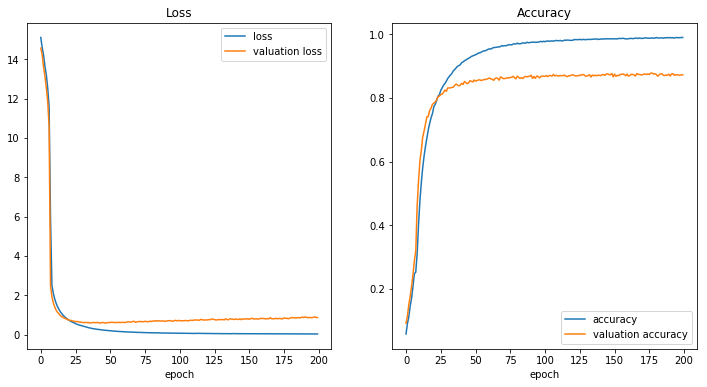

In [32]:
history=best_result.history
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history["loss"],label="loss")
plt.plot(history["val_loss"],label="valuation loss")
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["acc"],label="accuracy")
plt.plot(history["val_acc"],label="valuation accuracy")
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()

In [34]:
Y_pred=np.argmax(best_model.predict(features_test),axis=1)
np.mean(Y_pred==Y_test)

0.8727019928935579